In this notebook, we will build a decision tree classifier to predict whether a customer will purchase a product or service based on their demographic and behavioral data.

We will use a dataset such as the Bank Marketing dataset from the UCI Machine Learning Repository.

**Loading Libraries**

In [38]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from ucimlrepo import fetch_ucirepo 
import warnings
warnings.filterwarnings('ignore')

# Import dataset
bank_marketing = fetch_ucirepo(id=222) 

# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 

# Load dataset
data = pd.concat([X, y], axis=1)
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


**Checking Data types**

In [39]:
data.dtypes

age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
loan           object
contact        object
day_of_week     int64
month          object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

Input variables:

   **bank client data:**
   - age (numeric)
   - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   - education (categorical: "unknown","secondary","primary","tertiary")
   - default: has credit in default? (binary: "yes","no")
   - balance: average yearly balance, in euros (numeric) 
   - housing: has housing loan? (binary: "yes","no")
   - loan: has personal loan? (binary: "yes","no")
   **related with the last contact of the current campaign:**
   - contact: contact communication type (categorical: "unknown","telephone","cellular") 
   - day: last contact day of the month (numeric)
   - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   - duration: last contact duration, in seconds (numeric)
   **other attributes:**
   - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
   - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
   - previous: number of contacts performed before this campaign and for this client (numeric)
   - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):
  - y - has the client subscribed a term deposit? (binary: "yes","no")

## Data Cleaning

In [40]:
# Check missing values
missing_values = data.isnull().sum()
print(f"Missing values in each column:\n{missing_values[missing_values > 0]}")

# Fill missing job values with unknown
data['job'].fillna('unknown', inplace=True)
data['education'].fillna('unknown', inplace=True)
data['poutcome'].fillna('unknown', inplace=True)
data['contact'].fillna('unknown', inplace=True)

# Check missing values
missing_values = data.isnull().sum()
print(f"Missing values in each column:\n{missing_values[missing_values > 0]}")
data.head()

Missing values in each column:
job            288
education     1857
contact      13020
poutcome     36959
dtype: int64
Missing values in each column:
Series([], dtype: int64)


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


**Check for outliers using Z-score**

In [41]:
# Select only numerical columns for Z-score calculation
numerical_cols = data.select_dtypes(include=np.number).columns

# Calculate Z-scores for numerical columns
z_scores = data[numerical_cols].apply(zscore)

# Define a threshold for identifying outliers
threshold = 3

# Find outliers
outliers = (np.abs(z_scores) > threshold)

print("Number of outliers in each numerical column:")
print(outliers.sum())

# Display rows with outliers
outlier_rows = data[outliers.any(axis=1)]
print(f"\nTotal number of rows with at least one outlier: {len(outlier_rows)}")

# Save the cleaned data
data[~outliers.any(axis=1)].to_csv("bank_marketing_cleaned.csv", index=False)

Number of outliers in each numerical column:
age             381
balance         745
day_of_week       0
duration        963
campaign        840
pdays          1723
previous        582
dtype: int64

Total number of rows with at least one outlier: 5002


Since decision trees are not sensitive to the magnitude of values like other algorithms, I will leave the outliers in the dataset. The outliers may represent important variations in customer behavior.

In [42]:
# Creating age bins
bins = [0, 18, 30, 45, 60, 100]
labels = ['Children(0-17)', 'Young Adults(18-30)', 'Adults(31-45)', 'Middle Aged(46-60)', 'Elderly(60+)']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)
display(data.head())

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y,age_group
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,Middle Aged(46-60)
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,Adults(31-45)
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,Adults(31-45)
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,Middle Aged(46-60)
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,Adults(31-45)


**How Long did the calls last?**

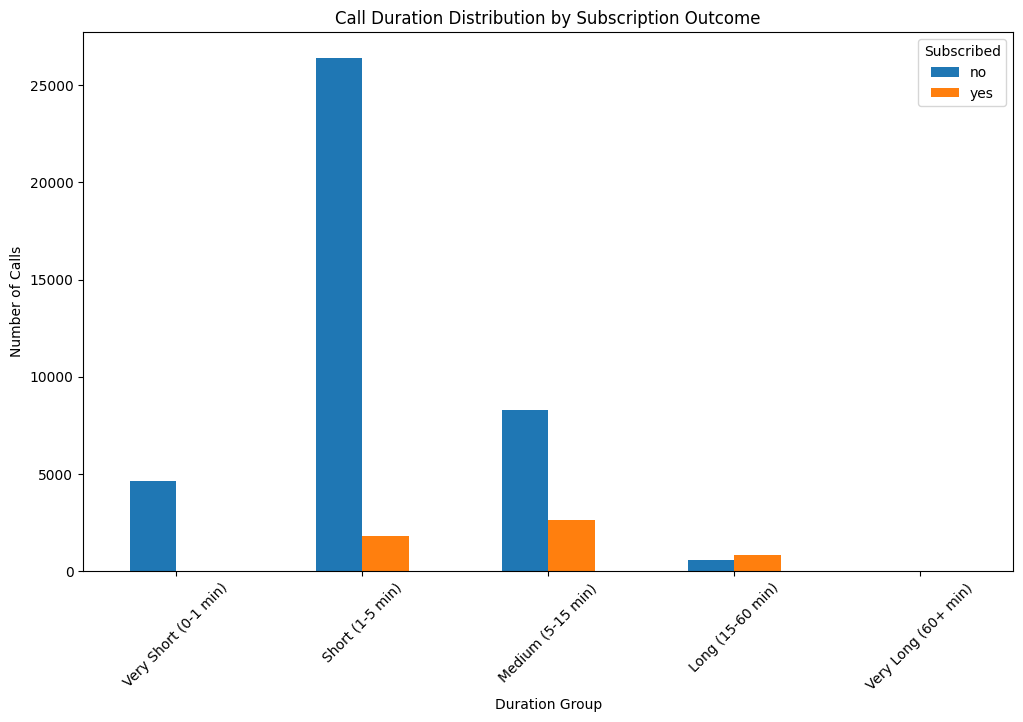

In [43]:
# Create bins for duration
bins = [0,60, 300, 900, 3600, 4900]
labels = ['Very Short (0-1 min)', 'Short (1-5 min)', 'Medium (5-15 min)', 'Long (15-60 min)', 'Very Long (60+ min)']
data['duration_group'] = pd.cut(data['duration'], bins=bins, labels=labels, right=False)

# Visualizing the distribution of call duration groups based on subscription outcome
duration_y_counts = data.groupby(['duration_group', 'y']).size().unstack()

duration_y_counts.plot(kind='bar', stacked=False, figsize=(12, 7))

plt.title('Call Duration Distribution by Subscription Outcome')
plt.xlabel('Duration Group')
plt.ylabel('Number of Calls')
plt.xticks(rotation=45)
plt.legend(title='Subscribed')
plt.show()

**Insights:**
- Calls that lasted less than 1 min had no customer that subscribed to the term deposit.
- The majority of calls lasted between 1 to 5 minutes, with a significant portion of these customers subscribing.
- Longer calls (15-60 min) had a higher proportion of subscriptions compared to shorter calls.
- Call duration appears to be a key factor in determining subscription likelihood. 

In [44]:
# Save the cleaned data
data.to_csv('Data/cleaned_bank_data.csv', index=False)